In [298]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [299]:
%reload_ext autoreload

In [334]:
import math
from pathlib import Path
import os
import tempfile
import shutil
import random

import cv2
from matplotlib import pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import keras
import numpy as np
from keras import layers
import matplotlib.pyplot as plt
from tensorflow import data as tf_data


import config
from template_matching import create_template, find_matching_templates
from models import double_tsek_classifier, double_tsek_detector

# Create Template

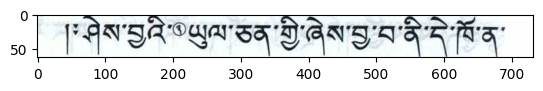

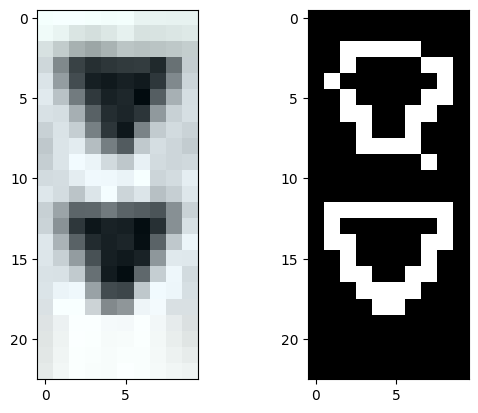

In [93]:
# image_fn = config.IMAGES_PATH / "W1PD95844" / "W1PD95844-I1PD95846" / "images" / "I1PD958460041.jpg"
# create_template(image_fn, "01", config.DOUBLE_TSEK_TEMPLATES_PATH, 2, 423, 429, 10, 25)
# create_template(image_fn, "02", config.DOUBLE_TSEK_TEMPLATES_PATH, 6, 453, 459, 15, 29)
# create_template(image_fn, "03", config.DOUBLE_TSEK_TEMPLATES_PATH, 9, 543, 550, 12, 26)

# image_fn = config.IMAGES_PATH / "W1PD95844" / "W1PD95844-I1PD95846" / "images" / "I1PD958460042.jpg"
# create_template(image_fn, "04", config.DOUBLE_TSEK_TEMPLATES_PATH, 2, 154, 161, 14, 28)

# image_fn = config.IMAGES_PATH / "W1PD95844" / "W1PD95844-I1PD95906" / "text_pages" / "I1PD959060618.jpg"
# create_template(image_fn, "05", config.DOUBLE_TSEK_TEMPLATES_PATH, 5, 205, 220, 12, 35)

# image_fn = config.IMAGES_PATH / "W1PD95844" / "W1PD95844-I1PD95906" / "text_pages" / "I1PD959060817.jpg"
# create_template(image_fn, "07", config.DOUBLE_TSEK_TEMPLATES_PATH, 8, 52, 62, 12, 35)

# Template Matching

In [26]:
images_path = config.IMAGES_PATH / "W1PD95844" / "W1PD95844-I1PD95906" / "text_pages"
image_fn_gen = images_path.iterdir()

I1PD959060618.jpg


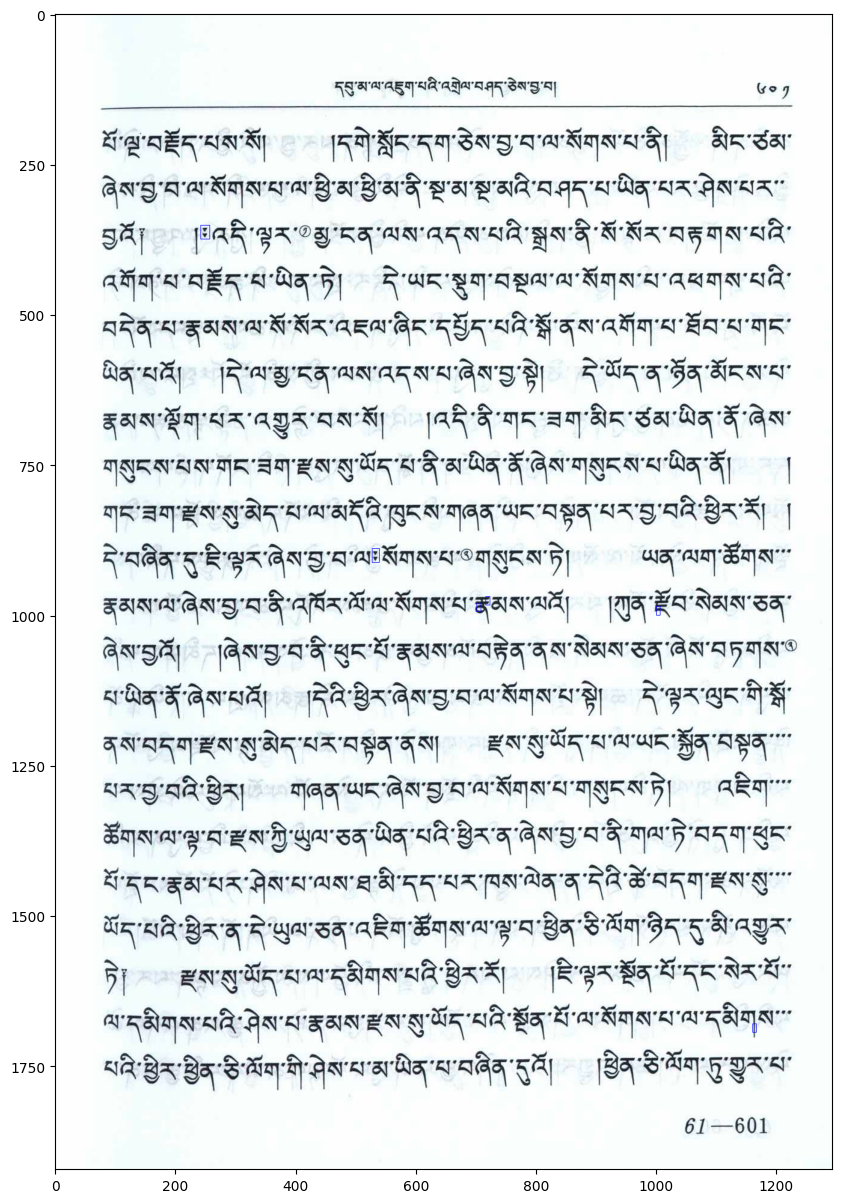

6

In [258]:
image_fn = next(image_fn_gen)
image_fn = config.IMAGES_PATH / "W1PD95844" / "W1PD95844-I1PD95906" / "text_pages" / "I1PD959060618.jpg"
print(image_fn.name)
matches = find_matching_templates(image_fn, config.DOUBLE_TSEK_TEMPLATES_PATH, imshow=True)
len(matches)

## Classification Dataset

In [112]:
def create_classifier_dataset_from_dir(images_path):
    data_save_path = config.DOUBLE_TSEK_CLASSIFIER_TRAINING_DATA / "no"
    data_save_path.mkdir(parents=True, exist_ok=True)
    for image_fn in tqdm(list(images_path.iterdir())):
        if not image_fn.name.endswith(".jpg"): continue
        image = cv2.imread(str(image_fn))
        matches = find_matching_templates(image_fn, config.DOUBLE_TSEK_TEMPLATES_PATH)
        if not matches: continue
        for i, (x, y, w, h) in enumerate(matches):
            match = image[y:y+h, x:x+w]
            match_name = f"{image_fn.stem}_{i+1:02}.jpg"
            match_path = data_save_path / match_name
            cv2.imwrite(str(match_path), match)

In [113]:
images_path = images_path = config.IMAGES_PATH / "W1PD95844" / "W1PD95844-I1PD95906" / "text_pages"
create_classifier_dataset_from_dir(images_path)

  0%|          | 0/1727 [00:00<?, ?it/s]

## Train Classification Model

In [118]:
def analyse_image_data_size():
    yes_data_path = config.DOUBLE_TSEK_CLASSIFIER_TRAINING_DATA / "yes"
    no_data_path = config.DOUBLE_TSEK_CLASSIFIER_TRAINING_DATA / "yes"
    
    widths = []
    heights = []
    for data_path in [yes_data_path, no_data_path]:
        for img_fn in tqdm(list(data_path.iterdir())):
            if not img_fn.name.endswith(".jpg"): continue
            h, w, _ = cv2.imread(str(img_fn)).shape
            widths.append(w)
            heights.append(h)

    print("Width")
    print("-\t max:", max(widths))
    print("-\t min:", min(widths))
    print("-\t avg:", round(sum(widths) / len(widths), 0))
    print("Height")
    print("-\t max:", max(heights))
    print("-\t min:", min(heights))
    print("-\t avg:", round(sum(heights) / len(heights), 0))

analyse_image_data_size()

  0%|          | 0/460 [00:00<?, ?it/s]

  0%|          | 0/460 [00:00<?, ?it/s]

Width
-	 max: 15
-	 min: 10
-	 avg: 14.0
Height
-	 max: 23
-	 min: 23
-	 avg: 23.0


In [194]:
data_path = config.DOUBLE_TSEK_CLASSIFIER_TRAINING_DATA / "data"

In [195]:
image_size = (23, 15)
batch_size = 128

In [196]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    str(data_path),
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 10293 files belonging to 2 classes.
Using 8235 files for training.
Using 2058 files for validation.


2024-05-17 10:42:59.137551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


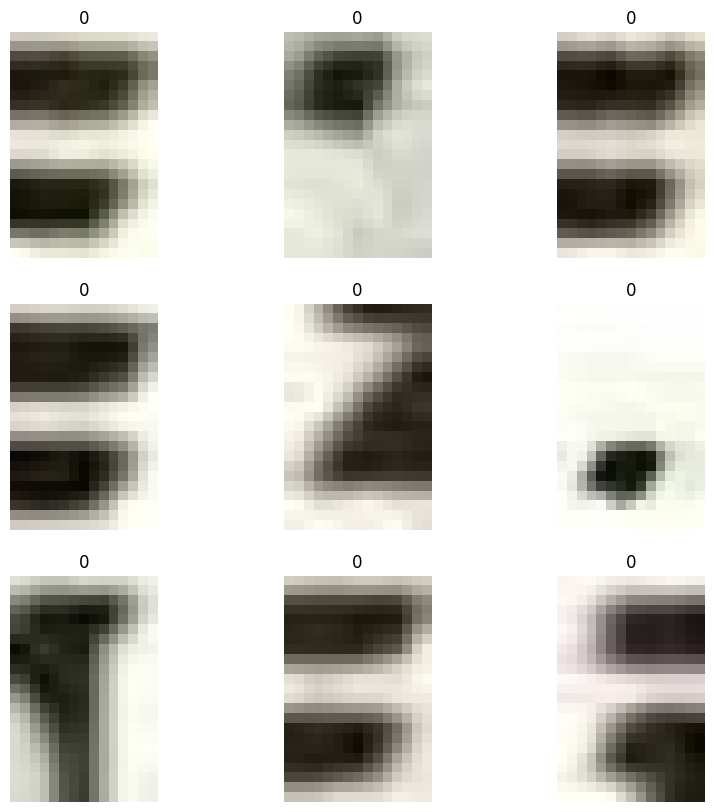

In [203]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [204]:
data_augmentation_layers = [
    layers.RandomContrast(0.5),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

2024-05-17 10:43:10.268117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


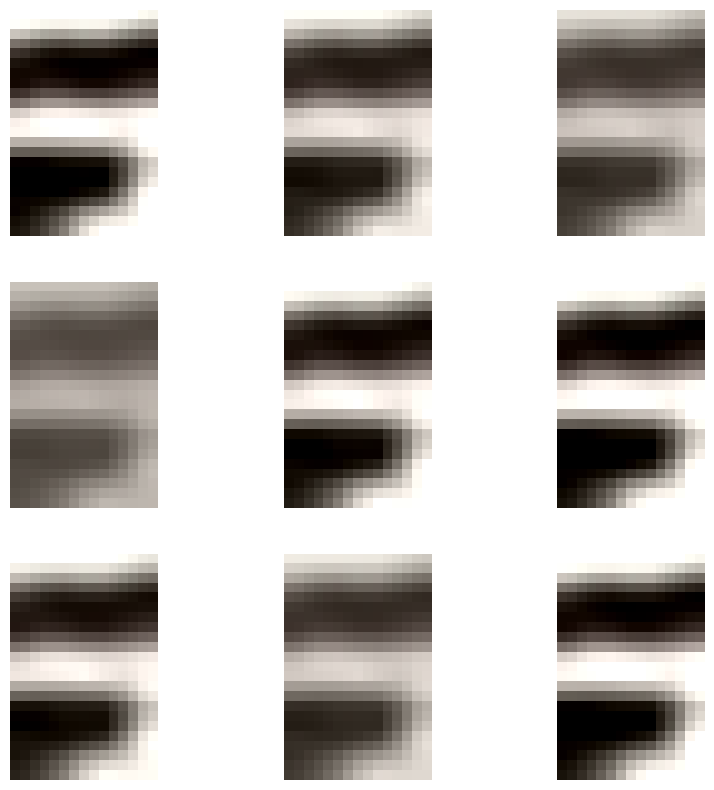

In [208]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [209]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [210]:
def make_model(input_shape, num_classes):
    units = 1 if num_classes == 2 else num_classes
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Rescaling(1.0 / 255),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(units, activation=None),
        ]
    )
    return model

model = make_model(input_shape=image_size + (3,), num_classes=2)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 23, 15, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 13, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,905 (77.75 KB)

 Trainable params: 19,905 (77.75 KB)

 Non-trainable params: 0 (0.00 B)

In [211]:
epochs = 25

model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
)

Epoch 1/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.8638 - loss: 0.5008 - val_acc: 0.8654 - val_loss: 0.3420
Epoch 2/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.8651 - loss: 0.3303 - val_acc: 0.8669 - val_loss: 0.1717
Epoch 3/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.9224 - loss: 0.1901 - val_acc: 0.9879 - val_loss: 0.0830
Epoch 4/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9440 - loss: 0.1413 - val_acc: 0.9903 - val_loss: 0.0526
Epoch 5/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9490 - loss: 0.1343 - val_acc: 0.9937 - val_loss: 0.0471
Epoch 6/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9762 - loss: 0.0754 - val_acc: 0.9947 - val_loss: 0.0334
Epoch 7/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9771 - loss: 0.0745 - val_acc: 0.9942 - val_loss: 0.0222
Epoch 8/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9849 - loss: 0.0501 - val_acc: 0.9971 - val_loss: 0.0207
Epoch 9/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9833

In [213]:
model_path = Path("models") / "double_tsek_classifier" / "double_tsek_classfier.keras"
model.save(model_path)

## Inference

In [227]:
gen_image_path = (config.DOUBLE_TSEK_CLASSIFIER_TRAINING_DATA / "data" / "yes").iterdir()

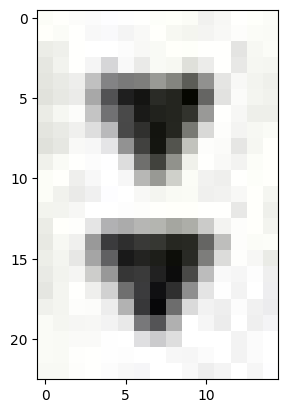

Note: 99.99%
It's a Note Marker


In [243]:
def inference(image_path, model, image_size=image_size, imshow=False):
    img = keras.utils.load_img(str(image_path), target_size=image_size)
    if imshow: plt.imshow(img); plt.show()
    img_array = keras.utils.img_to_array(img)
    img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis
    predictions = model.predict(img_array, verbose=0)
    score = float(keras.ops.sigmoid(predictions[0][0]))
    return score

image_path = next(gen_image_path)
# image_path = config.DOUBLE_TSEK_CLASSIFIER_TRAINING_DATA / "data" / "no" / "I1PD959061047_07.jpg"
score = inference(image_path, model, imshow=True)
print(f"Note: {100 * score:.2f}%")
if score > 0.9:
    print("It's a Note Marker")

### Classify Todo dataset

In [169]:
model_path = Path("models") / "double_tsek_classifier" / "double_tsek_classfier.keras"
todo_path = config.DOUBLE_TSEK_CLASSIFIER_TRAINING_DATA / "todo"
data_path = config.DOUBLE_TSEK_CLASSIFIER_TRAINING_DATA / "data"
yes_path = data_path / "yes"
no_path = data_path / "no"

In [170]:
model = keras.saving.load_model(model_path)

In [193]:
for image_fn in tqdm(list(no_path.iterdir())):
    if not image_fn.name.endswith(".jpg"): continue
    score = inference(image_fn, model)
    if score > 0.2:
        print(image_fn.name)
        dest_path = yes_path / image_fn.name
    else:
        dest_path = no_path / image_fn.name
    # shutil.move(str(image_fn), str(dest_path))

  0%|          | 0/8886 [00:00<?, ?it/s]

I1PD959061435_06.jpg
I1PD959061323_06.jpg
I1PD959061118_06.jpg
I1PD959060272_05.jpg
I1PD959061552_06.jpg
I1PD959060399_05.jpg
I1PD959061204_06.jpg
I1PD959060910_07.jpg


# Create YOLO Detection Dataset

In [343]:
def is_double_tsek(img, match):
    x, y, w, h = match
    match_img = img[y:y+h, x:x+w]
    # plt.imshow(match_img)
    # plt.show()
    with tempfile.TemporaryDirectory() as tmpdir:
        match_img_fn = Path(tmpdir) / "match.jpg"
        cv2.imwrite(str(match_img_fn), match_img)
        score = double_tsek_classifier.predict(match_img_fn)
        return True if score > 0.75 else False

def find_double_tseks(image_fn, model=True, check=False, imshow=False):
    img = cv2.imread(str(image_fn))
    if model:
        matches = list(double_tsek_detector.predict(image_fn, y_adjust=5))
        print(matches)
    else:
        matches = find_matching_templates(image_fn, config.DOUBLE_TSEK_TEMPLATES_PATH)

    if check:
        final_matches = [match for match in matches if is_double_tsek(img, match)]
    else:
        final_matches = matches

    if imshow:
        for x, y, w, h in final_matches:
            cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        plt.figure(figsize=(20, 15), dpi=100)
        plt.imshow(img)
        plt.show()
        
    return final_matches

In [356]:
image_fn_gen = (config.IMAGES_PATH / "W1PD96682" / "W1PD96682-I1PD96886" / "text_pages").iterdir()

[(840, 3234, 30, 47), (1186, 2149, 31, 47), (1416, 603, 30, 45), (1762, 1068, 30, 46), (2249, 452, 30, 46), (1478, 1685, 31, 47), (2142, 761, 31, 45), (643, 907, 29, 44), (1464, 1222, 28, 44), (806, 1218, 28, 44), (1884, 1377, 30, 47), (2459, 1071, 28, 47), (2393, 2776, 30, 45)]


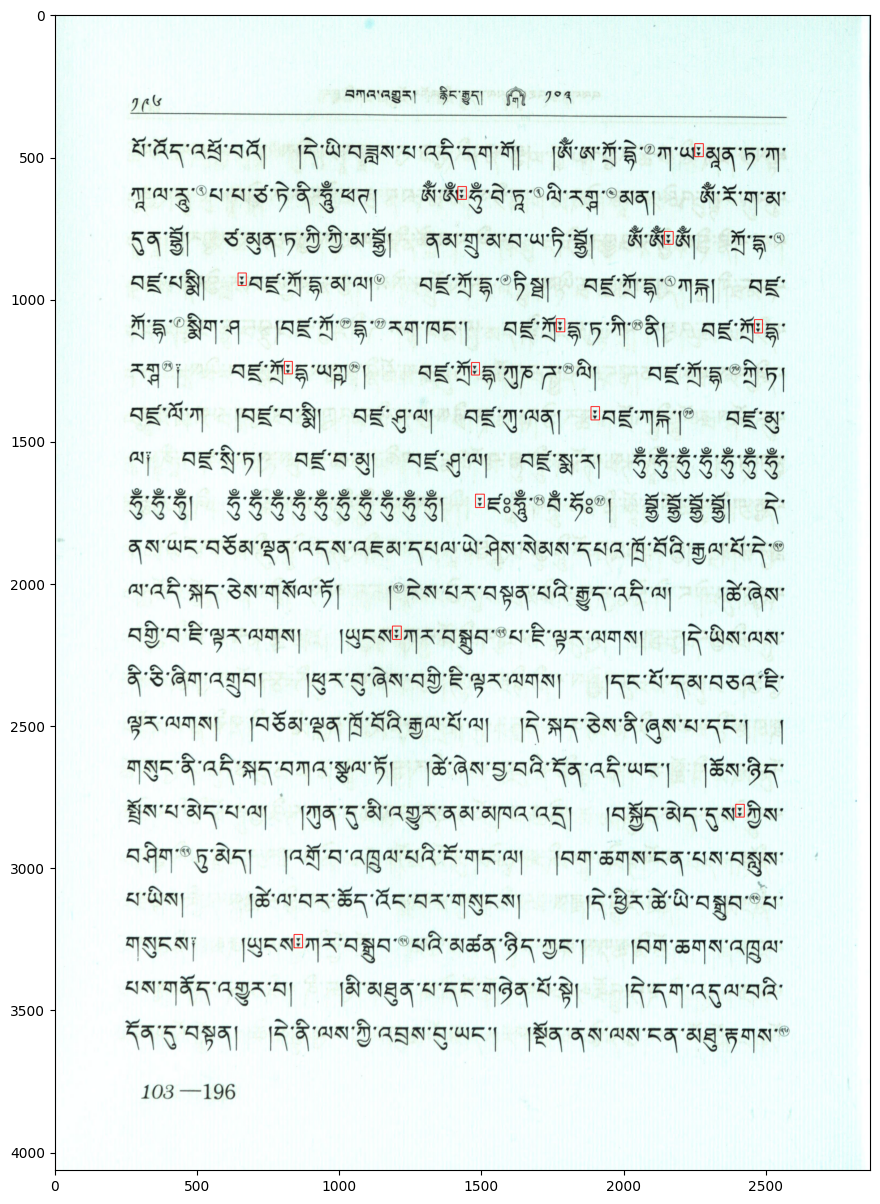

In [376]:
image_fn = next(image_fn_gen)
# image_fn = config.IMAGES_PATH / "W1PD95844" / "W1PD95844-I1PD95906" / "text_pages" / "I1PD959060500.jpg"
matches = find_double_tseks(image_fn, imshow=True)

In [261]:
detection_data_path = config.DOUBLE_TSEK_DETECTION_TRAINING_DATA / "data"

train_path = detection_data_path /  "train"
train_images_path = train_path / "images"
train_images_path.mkdir(parents=True, exist_ok=True)
train_labels_path = train_path / "labels"
train_labels_path.mkdir(parents=True, exist_ok=True)

valid_path = detection_data_path / "valid"
valid_images_path = valid_path / "images"
valid_images_path.mkdir(parents=True, exist_ok=True)
valid_labels_path = valid_path / "labels"
valid_labels_path.mkdir(parents=True, exist_ok=True)

In [292]:
def create_detection_dataset_v1(images_path, prefix):
    step = 0
    for image_fn in (pbar := tqdm(list(images_path.iterdir()))):
        pbar_descp = f"{images_path.parent.name.split('-')[-1]}"
        pbar.set_description(pbar_descp)
        if step > 5000: break
        if not image_fn.name.endswith(".jpg"): continue
        label_fn =  train_labels_path / f"{prefix}_{image_fn.stem}.txt"
        if label_fn.is_file(): continue
        image = cv2.imread(str(image_fn))
        img_height, img_width, _ = image.shape
        matches = find_double_tseks(image_fn)
        if not matches: continue
        dest_image_fn = train_images_path / f"{prefix}_{image_fn.name}"
        shutil.copy(str(image_fn), str(dest_image_fn))
        with label_fn.open("w+") as f:
            for i, (x, y, mw, mh) in enumerate(matches):
                x_center = round(((2*x+mw) / 2) / img_width, 6)
                y_center = round(((2*y+mw) / 2) / img_height, 6)
                w = round(mw / img_width, 6)
                h = round(mh / img_height, 6)
                label = f"0 {x_center} {y_center} {w} {h}".strip() + "\n"
                f.write(label)
        step += 1

In [293]:
images_path = config.IMAGES_PATH / "W1PD95844" / "W1PD95844-I1PD95906" / "text_pages"
create_detection_dataset_v1(images_path, "W1PD95844")

  0%|          | 0/1727 [00:00<?, ?it/s]

In [296]:
def split_detection_dataset():
    pages = [page.stem for page in train_images_path.iterdir()]
    random.shuffle(pages)
    valid_ds = pages[int((len(pages)+1)*.80):]

    for page in valid_ds:
        page_img_name = f"{page}.jpg"
        page_label_name = f"{page}.txt"
        page_img_fn = train_images_path / page_img_name
        dest_page_img_fn = valid_images_path / page_img_name
        shutil.move(str(page_img_fn), str(dest_page_img_fn))
        page_label_fn = train_labels_path / page_label_name
        dest_page_label_fn = valid_labels_path / page_label_name
        shutil.move(str(page_label_fn), str(dest_page_label_fn))

split_detection_dataset()

## Yolo Detector

In [317]:
def find_double_tseks(image_fn, imshow=False) -> list[tuple[int, int, int, int]]:      
    matches = list(double_tsek_detector.predict(image_fn))
    if imshow:
        img = cv2.imread(str(image_fn))
        for x, y, w, h in matches:
            cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        plt.figure(figsize=(20, 15), dpi=100)
        plt.imshow(img)
        plt.show()
    return matches

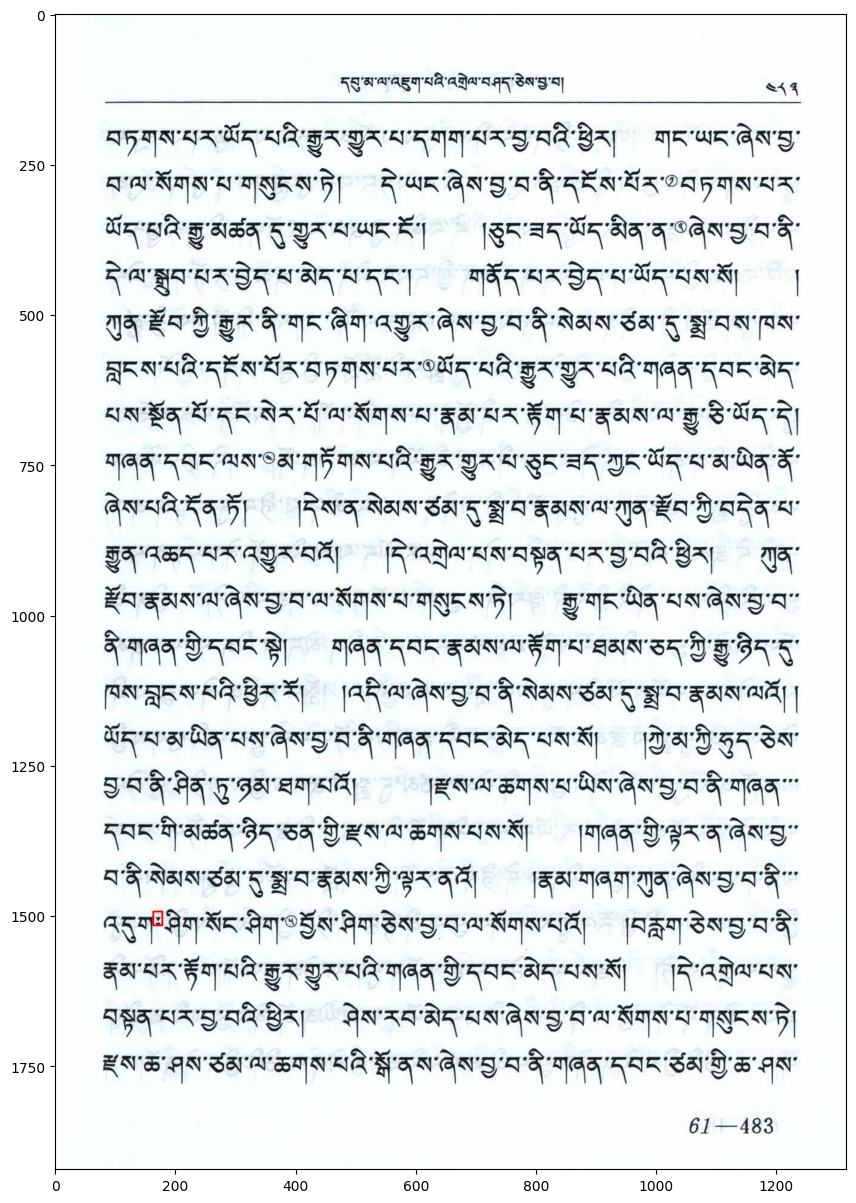

[(163, 1493, 15, 23)]

In [318]:
image_fn = config.IMAGES_PATH / "W1PD95844" / "W1PD95844-I1PD95906" / "text_pages" / "I1PD959060500.jpg"
find_double_tseks(image_fn, imshow=True)